# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
!pip install smdebug torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 3.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 805.7 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 38.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 1.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 11.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 38.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [4]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import os
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip
!aws s3 cp dogImages s3://sagemaker-us-east-1-028135097561/project/ --recursive
%%capture

--2023-05-08 11:09:01--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.144
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  46.9MB/s    in 25s     

2023-05-08 11:09:35 (43.6 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [44]:
BUCKET = 'sagemaker-us-east-1-028135097561'

os.environ['SM_CHANNEL_TRAINING']=f's3://{BUCKET}/'
os.environ['SM_MODEL_DIR']=f's3://{BUCKET}/model/'
os.environ['SM_OUTPUT_DATA_DIR']=f's3://{BUCKET}/output/'

data_channels = {
    "train": "s3://{}/train/".format(BUCKET),
    "test": "s3://{}/test/".format(BUCKET),
    "valid": "s3://{}/valid/".format(BUCKET)
}

role = sagemaker.get_execution_role()

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [45]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "learning-rate": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([16, 32, 64, 128, 256, 512]),
    "early-stopping-rounds": CategoricalParameter([10, 12, 15, 17, 20])
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: (\d+\.\d+)"}]

In [46]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="HP",
    role=role,
    framework_version="1.8.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version="py3",
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=2,
    objective_type=objective_type,
)


In [47]:
tuner.fit({"training": f"s3://{BUCKET}/"})


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..................................................................................................................................................................................................................................!


In [48]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()
print(best_estimator.hyperparameters())
hyperparameters = {"batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')), \
                   "learning-rate": best_estimator.hyperparameters()['learning-rate'],
                   "early-stopping-rounds": int(best_estimator.hyperparameters()['early-stopping-rounds'].replace('"', ''))
                  }
hyperparameters


2023-05-08 20:13:11 Starting - Found matching resource for reuse
2023-05-08 20:13:11 Downloading - Downloading input data
2023-05-08 20:13:11 Training - Training image download completed. Training in progress.
2023-05-08 20:13:11 Uploading - Uploading generated training model
2023-05-08 20:13:11 Completed - Resource retained for reuse
{'_tuning_objective_metric': '"Test Loss"', 'batch-size': '"32"', 'early-stopping-rounds': '"10"', 'learning-rate': '0.0033892446879010578', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"HP-2023-05-08-19-54-17-236"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-028135097561/HP-2023-05-08-19-54-17-236/source/sourcedir.tar.gz"'}


{'batch-size': 32,
 'learning-rate': '0.0033892446879010578',
 'early-stopping-rounds': 10}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [49]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "100",
        "eval.save_interval": "10"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [50]:
# TODO: Create and fit an estimator
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="MAIN",
    role=role,
    instance_count=2,
    instance_type="ml.g4dn.xlarge",
    framework_version="1.8.0",
    py_version="py3",
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)
estimator.fit({"training": f"s3://{BUCKET}/"})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: MAIN-2023-05-08-20-38-57-249


2023-05-08 20:38:59 Starting - Starting the training job...
2023-05-08 20:39:27 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-05-08 20:40:27 Downloading - Downloading input data.........
2023-05-08 20:42:07 Training - Downloading the training image...............
2023-05-08 20:44:28 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-05-08 20:44:32,728 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-05-08 20:44:32,758 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-05-08 20:44:32,761 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-05-08 20:44:33,007 sagemaker-training-toolkit INFO

In [51]:
#fetching jobname , client and description to be used for plotting.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
print(f"Jobname: {job_name}")
print(f"Client: {client}")
print(f"Description: {description}")

Jobname: MAIN-2023-05-08-20-38-57-249
Client: <botocore.client.SageMaker object at 0x7f8bf8ca8610>
Description: {'TrainingJobName': 'MAIN-2023-05-08-20-38-57-249', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:028135097561:training-job/MAIN-2023-05-08-20-38-57-249', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-028135097561/MAIN-2023-05-08-20-38-57-249/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch-size': '32', 'early-stopping-rounds': '10', 'learning-rate': '"0.0033892446879010578"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"MAIN-2023-05-08-20-38-57-249"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-028135097561/MAIN-2023-05-08-20-38-57-249/source/sourcedir.tar.gz"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.8.0-gpu-py3', 

In [52]:
# Define a Trail

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-05-08 21:16:04.047 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-05-08 21:16:04.057 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-028135097561/MAIN-2023-05-08-20-38-57-249/debug-output


[2023-05-08 21:16:07.303 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-05-08 21:16:08.323 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO trial.py:210] Loaded all steps
loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


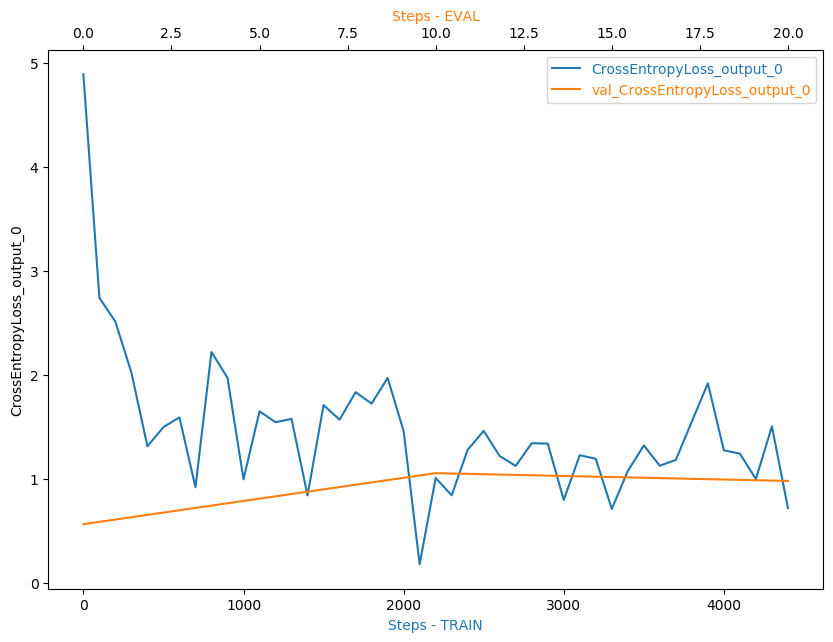

In [53]:
# TODO: Plot a debugging output.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

#utility function to get data from tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

#plot tensor utility functions for plotting tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps - TRAIN")
    par.set_xlabel("Steps - EVAL")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [54]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"Profiler report location: {rule_output_path}")

Profiler report location: s3://sagemaker-us-east-1-028135097561/MAIN-2023-05-08-20-38-57-249/rule-output


In [55]:
! aws s3 ls {rule_output_path} --recursive


2023-05-08 21:15:43     490282 MAIN-2023-05-08-20-38-57-249/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-05-08 21:15:43     357928 MAIN-2023-05-08-20-38-57-249/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-05-08 21:15:37        905 MAIN-2023-05-08-20-38-57-249/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-05-08 21:15:37      73900 MAIN-2023-05-08-20-38-57-249/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-05-08 21:15:37       2171 MAIN-2023-05-08-20-38-57-249/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-05-08 21:15:37        478 MAIN-2023-05-08-20-38-57-249/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-05-08 21:15:37       5007 MAIN-2023-05-08-20-38-57-249/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
2023-05-08 21:15:37        546 MAIN-2023-05-08-20-38-57-249/

In [56]:
! aws s3 cp {rule_output_path} ./ --recursive


download: s3://sagemaker-us-east-1-028135097561/MAIN-2023-05-08-20-38-57-249/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-028135097561/MAIN-2023-05-08-20-38-57-249/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-028135097561/MAIN-2023-05-08-20-38-57-249/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-028135097561/MAIN-2023-05-08-20-38-57-249/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-028135097561/MAIN-2023-05-08-20-38-57-249/rule-output/ProfilerReport/profiler-output/profil

In [57]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [58]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [67]:
# Zipping the ProfilerReport inorder to export and upload it later for submission
import shutil
shutil.make_archive("./profiler_repot.zip", "zip", "ProfilerReport")

'/root/udacity-nd009t-C2-Developing-ML-Workflow/udacity-nd009t-C2-Developing-ML-Workflow/project/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/profiler_repot.zip.zip'

## Model Deploying

In [91]:
# create ImagePredictor - without it the Image function won't be able to decode bytes
from sagemaker.predictor import Predictor
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer
        )

In [92]:
model_location=estimator.model_data
# model_location =  "s3://sagemaker-us-east-1-028135097561/MAIN-2023-05-08-20-38-57-249/output/model.tar.gz"
print(model_location)

s3://sagemaker-us-east-1-028135097561/MAIN-2023-05-08-20-38-57-249/output/model.tar.gz


In [93]:
from sagemaker.pytorch import PyTorchModel
pytorch_model = PyTorchModel(model_data=model_location, 
                             role=role, 
                             entry_point='inference.py',
                             py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [94]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

INFO:sagemaker:Creating model with name: pytorch-inference-2023-05-09-09-25-30-922
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-05-09-09-25-31-634
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-05-09-09-25-31-634


-----!

In [95]:
with open("test_image.jpg", "rb") as image:
    f = image.read()
    img_bytes = bytearray(f)

type(img_bytes)

bytearray

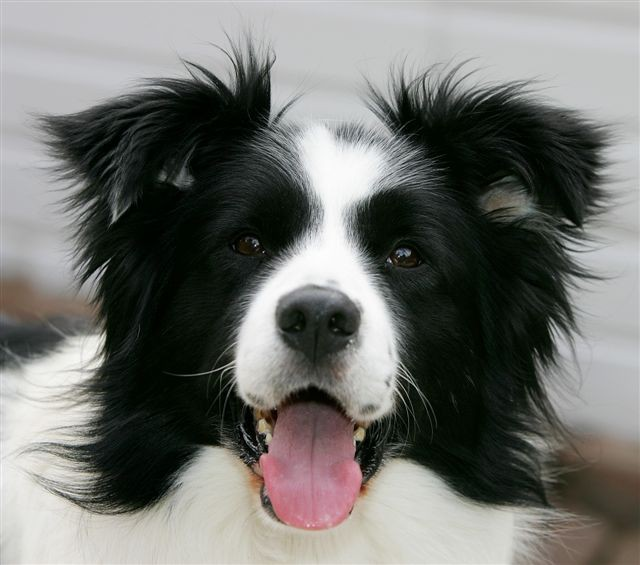

In [96]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [97]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})


In [98]:
print("Raw prediction result:")
print(response)
print()

labeled_predictions = list(zip(range(133), response[0]))
print("Labeled predictions: ")
print(labeled_predictions)
print()

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

Raw prediction result:
[[-19.641128540039062, -7.806684970855713, -22.27399253845215, -8.738227844238281, -5.277865886688232, -2.738422393798828, -22.40923500061035, -20.82259750366211, -15.958904266357422, -13.390660285949707, -5.531813621520996, 2.647737503051758, -16.187137603759766, -10.06462287902832, -31.768970489501953, -23.759552001953125, -7.10780668258667, -10.471709251403809, -20.71027183532715, -19.50069236755371, -3.9255170822143555, -14.004861831665039, -3.724477529525757, -20.145225524902344, -33.5923957824707, -23.082260131835938, -38.12834930419922, -29.310771942138672, 9.999226570129395, -28.689361572265625, -8.401429176330566, -18.51125144958496, -19.22670555114746, -36.956077575683594, -9.864317893981934, -17.619319915771484, -9.75107479095459, -27.87598419189453, -20.025903701782227, -34.63353729248047, -32.3001823425293, -18.548940658569336, -2.0118489265441895, -22.396461486816406, -6.534232139587402, -12.200977325439453, -11.3230562210083, -5.0737624168396, -5.6

In [ ]:
# Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()